<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Get-bands-3,-4,-5-fullsize-(green,-red,-near-ir)" data-toc-modified-id="Get-bands-3,-4,-5-fullsize-(green,-red,-near-ir)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get bands 3, 4, 5 fullsize (green, red, near-ir)</a></span></li><li><span><a href="#This-cell-reads-in-your-affine-transform,-metadata-and-profile" data-toc-modified-id="This-cell-reads-in-your-affine-transform,-metadata-and-profile-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>This cell reads in your affine transform, metadata and profile</a></span></li><li><span><a href="#This-cell-gets-the-right-reflection-function-for-your-satellite" data-toc-modified-id="This-cell-gets-the-right-reflection-function-for-your-satellite-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>This cell gets the right reflection function for your satellite</a></span></li><li><span><a href="#Define-a-subscene-window-and-a-transform" data-toc-modified-id="Define-a-subscene-window-and-a-transform-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define a subscene window and a transform</a></span></li><li><span><a href="#Read-only-the-window-pixels-from-the-band-3,-4,-5-files" data-toc-modified-id="Read-only-the-window-pixels-from-the-band-3,-4,-5-files-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Read only the window pixels from the band 3, 4, 5 files</a></span></li><li><span><a href="#In-the-next-cell-calculate-your-ndvi" data-toc-modified-id="In-the-next-cell-calculate-your-ndvi-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>In the next cell calculate your ndvi</a></span></li><li><span><a href="#In-the-next-cell-plot-a-mapped-ndvi-image-with-a-red-dot-in-your-ul-corner-and-a-white-dot-in-your-lr-corner" data-toc-modified-id="In-the-next-cell-plot-a-mapped-ndvi-image-with-a-red-dot-in-your-ul-corner-and-a-white-dot-in-your-lr-corner-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>In the next cell plot a mapped ndvi image with a red dot in your ul corner and a white dot in your lr corner</a></span></li></ul></div>

# Introduction

There are 4 cells that ask for changes below, the rest should run as long as you
use the variable names I ask for in the questions.

In [1]:
import rasterio
import a301
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from a301.landsat.landsat_metadata import landsat_metadata
import cartopy
from rasterio.windows import Window
from pyproj import transform as proj_transform
from pyproj import Proj
from a301.landsat.toa_reflectance import calc_reflc_8
import pprint
from a301.utils.data_read import download
from pathlib import Path
from affine import Affine
from IPython.display import Image
from a301.landsat.toa_reflectance import calc_refl_457, calc_reflc_8
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get bands 3, 4, 5 fullsize (green, red, near-ir)

At the end of this cell you shiould have the following path objects for your spring scene:

meta_bigfile, band3_bigfile, band4_bigfile, band5_bigfile

that point to your landsat TIF and mtl.txt files.

Note that landsat7 and landsat8 have their bands in different orders:

https://www.esri.com/arcgis-blog/products/product/imagery/band-combinations-for-landsat-8/

To deal switch between landsat8 and landsat7, set the landsat8 flag to True/False respectively



In [24]:
landsat8=True
spring=True
if landsat8:
    landsat_band_dict={'red':4,'green':3,'blue':2,'nearir':5,'thermal':10}
    if spring:
        season="spring"
        root="LC08_L1TP_190031_20170528_20170615_01_T1_"
#         prefix_remote=Path('landsat8/italy/spring')
        prefix_local=Path("landsat8/italy/spring")
    else:
        season="fall"
        root="LC08_L1TP_047026_20140203_20170307_01_T1_" #CHANGE THIS LATER
        prefix_remote=Path('landsat_scenes/l8_vancouver/fall')
        prefix_local=Path("landsat8/vancouver/fall")        
else:
    landsat_band_dict={'red':3,'green':2,'blue':1,'nearir':4,'thermal':'6_VCID_1'}
    if spring:
        season="spring"
        root="LE07_L1TP_190031_20170504_20170530_01_T1_"
#         prefix_remote=Path('landsat7/italy/spring')
        prefix_local=Path("landsat7/italy/spring")
    else:
        season="fall"
        root="LE07_L1TP_047026_20141110_20160904_01_T1_"
        prefix_remote=Path('landsat_scenes/l7_vancouver/fall')
        prefix_local=Path("landsat7/vancouver/fall")

name_dict=dict()
for key,band_num in landsat_band_dict.items():
    name_dict[key]=f"{root}B{band_num}.TIF"
    
dest_folder=a301.data_dir / prefix_local
dest_folder.mkdir(parents=True, exist_ok=True)

for key, the_file in name_dict.items():
    landsat_tif = prefix_remote / Path(the_file)
    download(str(landsat_tif),dest_folder=dest_folder)
    name_dict[key]= str(a301.data_dir / prefix_local / the_file)
    

the_file = Path(f"{root}MTL.txt")
mtl_file=prefix_remote / the_file
download(str(mtl_file),dest_folder=dest_folder)
name_dict['mtl']= str(a301.data_dir / prefix_local / the_file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat7/italy/spring/LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF
writing to: C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\landsat8\italy\spring\LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF

LC08_L1TP_190031_20170528_20170615_01_T1_B4.TIF already exists
and is 124751538 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat7/italy/spring/LC08_L1TP_190031_20170528_20170615_01_T1_B3.TIF
writing to: C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\landsat8\italy\spring\LC08_L1TP_190031_20170528_20170615_01_T1_B3.TIF

LC08_L1TP_190031_20170528_20170615_01_T1_B3.TIF already exists
and is 124751538 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/landsat7/italy/spring/LC08_L1TP_190031_20170528_20170615_01_T1_B2.TIF
writing to: C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\landsat8\italy\spring\LC08_L1TP_190031_20170528_20170615_01_T1_B

# This cell reads in your affine transform, metadata and profile

Using red band file for transform/profile information (arbitrary)

In [25]:
metadata=landsat_metadata(name_dict['mtl'])
satellite=metadata.SPACECRAFT_ID
with rasterio.open(name_dict['red']) as raster:
    big_transform=raster.transform
    big_profile=raster.profile

zone = metadata.UTM_ZONE  
crs = cartopy.crs.UTM(zone, southern_hemisphere=False)
p_utm=Proj(crs.proj4_init)
p_lonlat=Proj(proj='latlong',datum='WGS84')

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46


# This cell gets the right reflection function for your satellite

In [26]:
refl_dict={'LANDSAT_7':calc_refl_457,'LANDSAT_8':calc_reflc_8}         
satellite=metadata.SPACECRAFT_ID
refl_fun=refl_dict[satellite]

# Define a subscene window and a transform

In the cell below, get the upper left col,row (ul_col,ul_row) and upper left and lower
right x,y (ul_x,ul_y,lr_x,lr_y)
coordinates the upper left corner of 
your subscene as in the image_zoom notebook.  Use ul_col, ul_row, ul_x, ul_y plus your subscene
width and height to make a rasterio window and new transform.

    window=Window(ul_col, ul_row, small_width, small_height)
    new_affine=Affine(30.,0.,ul_x,0.,-30.,ul_y)
    extent = [ul_x,lr_x,lr_y,ul_y]


In [58]:
### BEGIN SOLUTION
ubc_lon = 13.66477
ubc_lat = 41.75983
ubc_x, ubc_y =proj_transform(p_lonlat,p_utm,ubc_lon, ubc_lat) 
ubc_col, ubc_row = ~big_transform*(ubc_x,ubc_y)
ubc_col, ubc_row = int(ubc_col), int(ubc_row)
l_col_offset= 0
t_row_offset= 0
width=2500
height=2500
ul_col=ubc_col + l_col_offset
ul_row=ubc_row + t_row_offset
ul_x,ul_y = big_transform*(ul_col,ul_row)
lr_x,lr_y = big_transform*(ul_col + width, ul_row + height)
small_window=Window(ul_col, ul_row, width, height)
new_affine=Affine(30.,0.,ul_x,0.,-30.,ul_y)
extent = [ul_x,lr_x,lr_y,ul_y]
### END SOLUTION

# Read only the window pixels from the band 3, 4, 5 files

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46
Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46
Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46
Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46
Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46


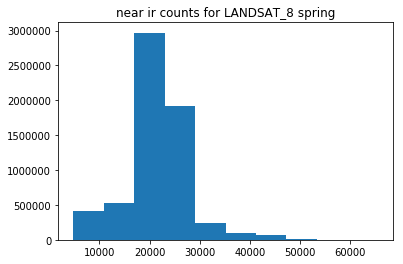

In [59]:
metadata_string=str(name_dict['mtl'])
refl_dict=dict()
for key in ['red','green','blue','nearir']:
    filepath=name_dict[key]
    bandnum=landsat_band_dict[key]
    with rasterio.open(filepath) as src:
        counts = src.read(1, window=small_window)
        counts=counts.astype(np.float32)
        counts[counts==0.]=np.nan
        #counts = src.read(1)
        refl_vals = refl_fun(counts,bandnum,metadata_string)
        refl_dict[key]=refl_vals
metadata=landsat_metadata(name_dict['mtl'])
plt.hist(counts[~np.isnan(counts)].flat)
plt.title(f'near ir counts for {satellite} {season}');

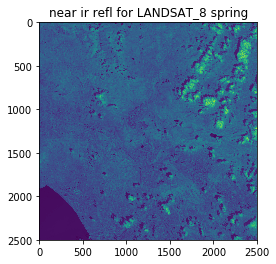

In [53]:
plt.imshow(refl_dict['nearir'])
plt.title(f'near ir refl for {satellite} {season}');

# In the next cell calculate your ndvi

Save it in a variable called ndvi

In [54]:
### BEGIN SOLUTION
ndvi = (refl_dict['nearir'] - refl_dict['red'])/(refl_dict['nearir'] + refl_dict['red'])
### END SOLUTION

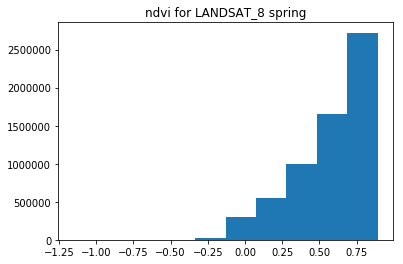

In [55]:
plt.hist(ndvi[~np.isnan(ndvi)].flat)
plt.title(f'ndvi for {satellite} {season}');

# In the next cell plot a mapped ndvi image with a red dot in your ul corner and a white dot in your lr corner

Adjust this plot to fit your image.  Just delete the bottom line and work with the provided commands

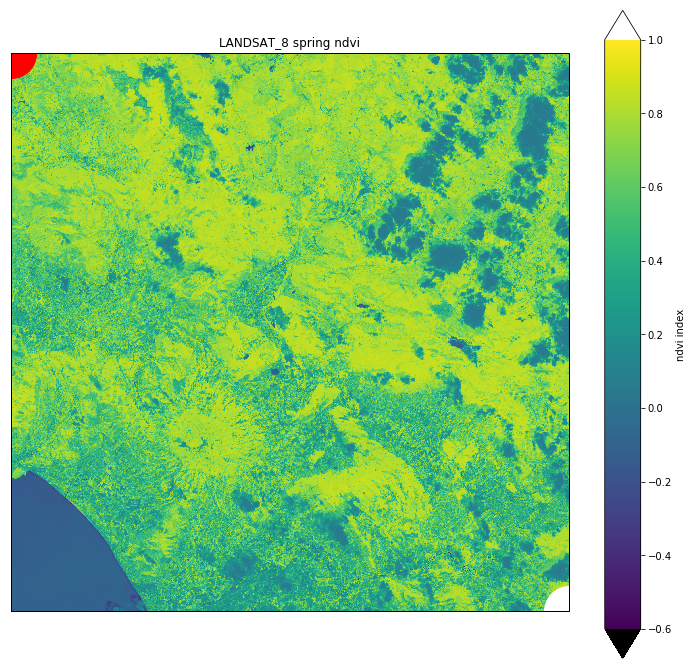

In [56]:
vmin=-0.6
vmax=1
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
palette='viridis'
pal = plt.get_cmap(palette)
pal.set_bad('0.75') #75% grey for out-of-map cells
pal.set_over('w')  #color cells > vmax red
pal.set_under('k')  #color cells < vmin black
fig, ax = plt.subplots(1, 1,figsize=[10,15],
                       subplot_kw={'projection': crs})
col=ax.imshow(ndvi,origin="upper",
         extent=extent,transform=crs,norm=the_norm)
ax.plot(ul_x,ul_y,'ro',markersize=50)
ax.plot(lr_x,lr_y,'wo',markersize=50)
ax.set(title=f"{satellite} {season} ndvi")
cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])
cbar=ax.figure.colorbar(col,extend='both',cax=cbar_ax,orientation='vertical')
cbar.set_label('ndvi index')
### BEGIN SOLUTION
#your plot should appear below
### END SOLUTION